In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from cleanplots import *
from tqdm import tqdm
from information_estimation import gaussian_entropy_estimate, nearest_neighbors_entropy_estimate
from image_utils import *
from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM


In [65]:
# generate multivariate gaussian data
X = onp.random.multivariate_normal(onp.zeros(8), onp.eye(8), size=10000)

print(gaussian_entropy_estimate(X))
print(nearest_neighbors_entropy_estimate(X, k=10))

16.35653
16.132664


In [3]:
def create_images(size, type, num_images, channel=None,
                   num_images_for_cov_estimation=10000, num_patches=50000, edge_crop=32, 
                   median_filter=False):
    """
    Get a distribution of images 

    Parameters
    ----------
    size : int  size of images
    type : str  'led_array' for BSCCM images, 'stationary_GP' for gaussian process images derived
                from BSCCM images
    num_images : int  number of images to generate
    channel : str  channel to use for BSCCM images
    num_images_for_cov_estimation : int  number of BSCCM images to use for covariance estimation
    num_patches : int  number of patches to use for covariance estimation   
    edge_crop : int  number of pixels to crop from the edge of BSCCM images when estimating covariance
    median_filter : bool  whether to median filter BSCCM images
    """
    if type == 'stationary_GP':
        # Generate gaussian process images based on the statistics of LED array images of cells
        patch_size = size # the size of patches to estimate the covariance matrix from
        images = load_bsccm_images(bsccm, channel, num_images=num_images_for_cov_estimation, 
                                   edge_crop=edge_crop, convert_units_to_photons=True, median_filter=median_filter)
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, seed=1234)
        print('computing cov mat')
        cov_mat = compute_stationary_cov_mat(patches)
        mean = np.mean(patches)
        print('making positive definite')
        cov_mat = make_positive_definite(cov_mat, cutoff_percentile=25, show_plot=False)
        images, patches = None, None # free memory
        # generate images
        images = generate_stationary_gaussian_process_samples(cov_mat, size, num_images, mean=mean)
        return np.array(images)
    elif type == 'led_array':
        # load median filtered images of cells from LED array
        crop_size = bsccm.global_metadata['led_array']['image_shape'][0] - 2 * edge_crop
        images = load_bsccm_images(bsccm, channel, num_images=num_images, 
                                   edge_crop=edge_crop, convert_units_to_photons=True,
                                   median_filter=median_filter)
        # for each image, crop to a random square patch
        num_images = images.shape[0]
        cropped_images = []
        for image in images:
            # choose a random location to crop from
            x = onp.random.randint(0, crop_size - size)
            y = onp.random.randint(0, crop_size - size)
            # crop the image
            cropped_images.append(image[y:y + size, x:x + size])
        return np.array(cropped_images)


@jit
def compute_conditional_entropy(images, gaussian_noise_sigma=None):
    """
    Compute the conditional entropy H(Y | X) where Y is a random noisy
    realization of a random clean image X

    images : ndarray clean image HxW or images NxHxW
    """
    # vectorize
    images = images.reshape(-1, images.shape[-2] * images.shape[-1])
    
    if gaussian_noise_sigma is None:
        
        # conditional entropy H(Y | x) for Poisson noise (see derivation in paper)
        return np.mean(0.5 * (images.shape[0] * np.log2(2 * np.pi * np.e) + np.sum(np.log2(images), axis=1)))
    else:
        # conditional entropy H(Y | x) for Gaussian noise
        # only depends on the gaussian sigma
        return np.mean(np.sum(images.shape[-1] * 0.5 * np.log2(2 * np.pi * np.e * gaussian_noise_sigma**2), axis=1))
        

## Is H(Y | X) well approximated by H(Y_theoretical | Y_experimental)

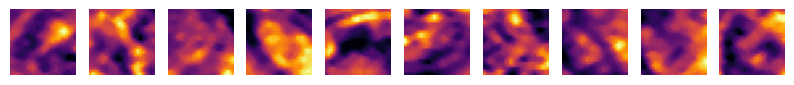

In [4]:
# generate images and plot a montage
size = 18
num_images = 40000
# channel = 'DPC_Right'
channel = 'LED119'

images = create_images(size, 'led_array', num_images, channel=channel, median_filter=True, edge_crop=32)  
# images = create_images(size, 'gaussian', num_images, channel=channel, median_filter=True, edge_crop=32)  

# plot a montage of images
num_to_plot = 10
fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
for i in range(num_to_plot):
    ax[i].imshow(images[i], cmap='inferno')
    ax[i].axis('off')




In [5]:
# def estimate_mutual_information(images):
#     H_y = gaussian_entropy_estimate(noisy_images.reshape(noisy_images.shape[0], -1))
    

noisy_images = np.array(add_shot_noise(images))

h_y_given_x_true = compute_conditional_entropy(images)
h_y_given_x_noisy_approx = compute_conditional_entropy(noisy_images)

print('conditional entropy clean: ', h_y_given_x_true)
print('conditional entropy noisy approx: ', h_y_given_x_noisy_approx)


h_y_gaussian = gaussian_entropy_estimate(noisy_images, stationary=False)
h_y_nearest_neighbors = nearest_neighbors_entropy_estimate(noisy_images, k=10)

print('h_y_gaussian: ', h_y_gaussian, 'h_y_nearest_neighbors: ', h_y_nearest_neighbors)


conditional entropy clean:  84550.836
conditional entropy noisy approx:  84550.18


2023-09-18 16:20:49.759512: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 23.84GiB (rounded to 25600000256)requested by op 
2023-09-18 16:20:49.759630: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:497] **__________________________________________________________________________________________________
2023-09-18 16:20:49.759781: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2410] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 25600000024 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   95.37MiB
              constant allocation:         4B
        maybe_live_out allocation:         4B
     preallocated temp allocation:   23.84GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:   23.93GiB
              total

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 25600000024 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   95.37MiB
              constant allocation:         4B
        maybe_live_out allocation:         4B
     preallocated temp allocation:   23.84GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:   23.93GiB
              total fragmentation:        45B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 5.96GiB
		Operator: op_name="jit(_do_nearest_neighbors_entropy_estimate)/jit(main)/jit(nearest_neighbors_distance)/jit(argsort)/sort[dimension=1 is_stable=True num_keys=1]" source_file="/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py" source_line=43
		XLA Label: sort
		Shape: s32[40000,40000]
		==========================

	Buffer 2:
		Size: 5.96GiB
		Operator: op_name="jit(_do_nearest_neighbors_entropy_estimate)/jit(main)/jit(nearest_neighbors_distance)/jit(argsort)/sort[dimension=1 is_stable=True num_keys=1]" source_file="/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py" source_line=43
		XLA Label: sort
		Shape: s32[40000,40000]
		==========================

	Buffer 3:
		Size: 5.96GiB
		Operator: op_name="jit(_do_nearest_neighbors_entropy_estimate)/jit(main)/jit(nearest_neighbors_distance)/jit(argsort)/sort[dimension=1 is_stable=True num_keys=1]" source_file="/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py" source_line=43
		XLA Label: sort
		Shape: f32[40000,40000]
		==========================

	Buffer 4:
		Size: 5.96GiB
		Operator: op_name="jit(_do_nearest_neighbors_entropy_estimate)/jit(main)/jit(nearest_neighbors_distance)/jit(argsort)/iota[dtype=int32 shape=(40000, 40000) dimension=1]" source_file="/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py" source_line=43
		XLA Label: iota
		Shape: s32[40000,40000]
		==========================

	Buffer 5:
		Size: 95.37MiB
		Entry Parameter Subshape: f32[40000,25,25]
		==========================

	Buffer 6:
		Size: 24B
		Operator: op_name="jit(_do_nearest_neighbors_entropy_estimate)/jit(main)/jit(nearest_neighbors_distance)/jit(argsort)/sort[dimension=1 is_stable=True num_keys=1]" source_file="/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py" source_line=43
		XLA Label: sort
		Shape: (f32[40000,40000], s32[40000,40000], s32[40000,40000])
		==========================

	Buffer 7:
		Size: 4B
		XLA Label: parameter
		Shape: f32[]
		==========================

	Buffer 8:
		Size: 4B
		XLA Label: parameter
		Shape: s32[]
		==========================

	Buffer 9:
		Size: 4B
		XLA Label: parameter
		Shape: s32[]
		==========================

	Buffer 10:
		Size: 4B
		XLA Label: parameter
		Shape: s32[]
		==========================

	Buffer 11:
		Size: 4B
		XLA Label: parameter
		Shape: s32[]
		==========================

	Buffer 12:
		Size: 4B
		Operator: op_name="jit(_do_nearest_neighbors_entropy_estimate)/jit(main)/reduce_sum[axes=(0,)]" source_file="/tmp/ipykernel_16703/520779777.py" source_line=66
		XLA Label: add
		Shape: f32[]
		==========================

	Buffer 13:
		Size: 4B
		XLA Label: parameter
		Shape: f32[]
		==========================

	Buffer 14:
		Size: 4B
		XLA Label: parameter
		Shape: f32[]
		==========================

	Buffer 15:
		Size: 4B
		XLA Label: parameter
		Shape: f32[]
		==========================

